In [37]:
import json
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import cumtrapz, simpson
from scipy.signal import butter, filtfilt, iirnotch, spectrogram, welch
from glob import glob

In [66]:
class EmgPreprocessing:
    def __init__(self, filepath: str, pointspath: str, kf: float = None) -> None:
        data = pd.read_csv(filepath)
        self.raw = data.to_numpy()
        self.x = self.raw[:, 0]
        self.y = self.raw[:, 1:] * kf if kf is not None else self.raw[:, 1:]  #* (3100 - 150) / 1000 / 65535

        with open(pointspath, "r") as f:
            self.points = json.load(f)
    
    def baseline(self, time_point: float = None):
        time_point = time_point if time_point is not None else self.points["baseline"]
        baseline_idx = np.argwhere(self.x >= time_point)[0][0]
        baseline = self.y[:baseline_idx, :]
        x0 = np.mean(baseline, axis=0)
        normalize = self.y - x0
        yf = np.argwhere(self.x >= 22)[0][0]

        self.x = self.x[baseline_idx:yf]
        self.y = normalize[baseline_idx:yf, :]
        return self
    
    def bandpass(self, sfreq: float = 1000, low: float = 450, high: float = 20):
        high = high/(sfreq/2)
        low = low/(sfreq/2)
        b, a = butter(4, [high, low], btype='bandpass')
        self.y = np.vstack([filtfilt(b, a, self.y[:, i]) for i in range(self.y.shape[1])]).T
        return self
    
    def notch(self, freq: float = 50, sfreq: float = 1000):
        b, a = iirnotch(freq, 30.0, sfreq)
        self.y = np.vstack([filtfilt(b, a, self.y[:, i]) for i in range(self.y.shape[1])]).T
        return self
    
    def lowpass(self, sfreq: float = 1000, low: float = 10):
        low = low/(sfreq/2)
        b, a = butter(4, low, btype='lowpass')
        self.y = np.vstack([filtfilt(b, a, self.y[:, i]) for i in range(self.y.shape[1])]).T
        return self
    
    def rectification(self):
        self.y = np.abs(self.y)
        return self
    
    def power(self, mode: Literal["simps", "rms"] = "simps") -> np.ndarray:
        if mode == "simps":
            return simpson(np.power(self.y, 2), axis=0)

        if mode == "rms":
            return np.sqrt(np.mean(np.power(self.y, 2), axis=0))

        return simpson(np.power(self.y, 2), axis=0)

    def save(self, name: str):
        columns = ["x"] + [f"y{i}" for i in range(self.y.shape[1])]
        data = np.hstack([self.x[:, np.newaxis], self.y])
        pd.DataFrame(data, columns=columns).to_csv(name, index=False)
        
        
        

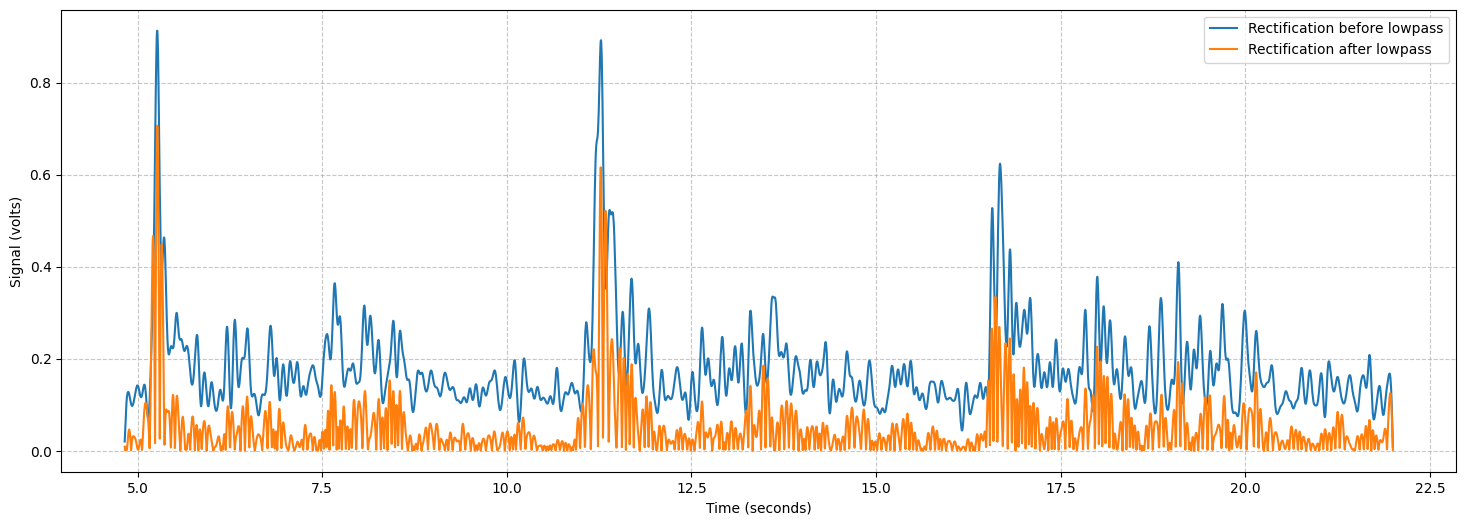

In [67]:
process1 = EmgPreprocessing("../data/rest_time/10min/exp_1.csv", "../data/rest_time/10min/exp_1_points.json", 3.3 / 65535)
process = EmgPreprocessing("../data/rest_time/10min/exp_1.csv", "../data/rest_time/10min/exp_1_points.json", 3.3 / 65535)

# process1.baseline().notch().bandpass(1000, 400, 15).lowpass(1000, 40).rectification()
process.baseline().bandpass(1000, 400, 15).notch().rectification().lowpass(1000, 40)
process1.baseline().bandpass(1000, 400, 15).notch().lowpass(1000, 40).rectification()

plt.figure(figsize=(18, 6))
plt.plot(process.x, process.y[:, 0], label="Rectification before lowpass")
plt.plot(process1.x, process1.y[:, 0], label="Rectification after lowpass")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (volts)")
plt.legend()
plt.show()

In [76]:
intervals = ["1min", "5min", "10min"]
power = []
for k, interval in enumerate(intervals):
    power.append([])
    for i in range(1, 6):
        filepath = f"../data/rest_time/{interval}/exp_{i}.csv"
        pointspath = f"../data/rest_time/{interval}/exp_{i}_points.json"
        process = EmgPreprocessing(filepath, pointspath, 3.3 / 65535)
        process.baseline().bandpass(1000, 400, 15).notch().rectification().lowpass(1000, 40)
        process.save(f"data/rest/data_{interval}_exp_{i}.csv")
        power[k].append(process.power("simps")[0])
pd.DataFrame(np.array(power).T, columns=intervals).to_csv("data/rest/power.csv")

In [80]:
power = []
for i in range(1, 11):
    filepath = f"../data/sitting/exp_{i}.csv"
    pointspath = f"../data/sitting/exp_{i}_points.json"
    process = EmgPreprocessing(filepath, pointspath, 3.3 / 65535)
    process.baseline().bandpass(1000, 400, 15).notch().rectification().lowpass(1000, 40)
    process.save(f"data/position/data_exp_{i}.csv")
    power.append(process.power("simps"))
pd.DataFrame(np.array(power), columns=["knee", "thigh", "pelvis"]).to_csv("data/position/power.csv")